In [2]:
import numpy as np
import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

import matplotlib.gridspec as gridspec

from tensorflow.keras.models import load_model

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error

from predict import predict

/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cl19abx/Learning_SFHs/venv/lib64/python3

In [3]:
si = predict(fname='data/full_histories_illustris.h5')
si.training_mask()
si.filename

se = predict(fname='data/full_histories_eagle.h5')
se.training_mask()

prediction = {}
model = {}
features = {}
predictors = {}

In [4]:
sn = 50

## Illustris
illustris_dust, wl = si.load_spectra('Dust')
illustris_dust_noise = si.add_noise_flat(spec=illustris_dust, wl=wl, sn=sn)
si.generate_standardisation(key='Dust Noise SN50', spec=illustris_dust_noise)
features['illustris'] = si.prepare_features(illustris_dust_noise, key='Dust Noise SN50', CNN=True)
predictors['illustris'] = si.load_arr('log_8','SFH')
model['illustris'] = load_model('data/cnn_trained_illustris_dust_noise50_x4.h5',
                                custom_objects={'_SMAPE_tf': si._SMAPE_tf})

prediction['illustris-illustris'] = model['illustris'].predict(features['illustris'][~si.train])


## EAGLE
eagle_dust, wl = se.load_spectra('Dust')
eagle_dust_noise = se.add_noise_flat(spec=eagle_dust, wl=wl, sn=sn)
se.generate_standardisation(key='Dust Noise SN50', spec=eagle_dust_noise)
features['eagle'] = se.prepare_features(eagle_dust_noise, key='Dust Noise SN50', CNN=True)
predictors['eagle'] = se.load_arr('log_8','SFH')
model['eagle'] = load_model('data/cnn_trained_eagle_dust_noise50_x4.h5',
                            custom_objects={'_SMAPE_tf': se._SMAPE_tf})

prediction['eagle-eagle'] = model['eagle'].predict(features['eagle'][~se.train])


Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
# use scaler trained on original data
features['illustris-eagle_scaler'] = si.prepare_features(illustris_dust_noise, 
                                        scaler=se.scalers['Dust Noise SN50'],
                                        key='Dust Noise SN50', CNN=True)

features['eagle-illustris_scaler'] = se.prepare_features(eagle_dust_noise, 
                                        scaler=si.scalers['Dust Noise SN50'],
                                        key='Dust Noise SN50', CNN=True)

prediction['illustris-eagle'] = \
    model['illustris'].predict(features['eagle-illustris_scaler'])

prediction['eagle-illustris'] = \
    model['eagle'].predict(features['illustris-eagle_scaler'])

## SMAPE distribution

In [6]:
SMAPE = {}

SMAPE['illustris-illustris'] = np.array([si._SMAPE(predictors['illustris'][~si.train][i], 
                                         prediction['illustris-illustris'][i]) \
                                         * 100 for i in range(np.sum(~si.train))])

SMAPE['eagle-eagle'] = np.array([si._SMAPE(predictors['eagle'][~se.train][i], 
                                 prediction['eagle-eagle'][i]) \
                                 * 100 for i in range(np.sum(~se.train))])

SMAPE['illustris-eagle'] = np.array([si._SMAPE(predictors['eagle'][i], 
                                     prediction['illustris-eagle'][i]) \
                                     * 100 for i in range(len(predictors['eagle']))])

SMAPE['eagle-illustris'] = np.array([si._SMAPE(predictors['illustris'][i], 
                                     prediction['eagle-illustris'][i]) \
                                     * 100 for i in range(len(predictors['illustris']))])


eagle-eagle
eagle-illustris
illustris-illustris
illustris-eagle


/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()


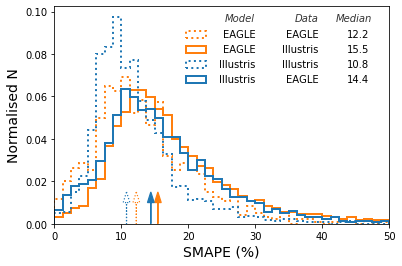

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

max_count = 0.
max_range = 50

for i, (key,model_str,data_str,c,ls,f) in enumerate(
    zip(['eagle-eagle', 'eagle-illustris', 
         'illustris-illustris', 'illustris-eagle'],
        ['EAGLE','EAGLE','Illustris','Illustris'],
        ['EAGLE','Illustris','Illustris','EAGLE'],
        ['C1','C1','C0','C0'],
        ['dotted','solid','dotted','solid'],
        [False,True,False,True])):
    print(key)
    counts = ax.hist(SMAPE[key], bins=40, range=(0, max_range), label=key, 
                     alpha=1, color=c, histtype='step', ls=ls, lw=2, normed=True)
    
    max_count = np.max([max_count, np.max(counts[0])])
    
    ax.text(0.94, 0.86-(i*0.07), '%.1f'%np.median(SMAPE[key]), 
            horizontalalignment='right', transform=ax.transAxes)
    
    ax.arrow(np.median(SMAPE[key]), 0, 0, 0.01, head_width=1, head_length=0.005, 
             fc=c, ec=c, ls=ls, fill=f, lw=1.2, alpha=1)
    
    ax.text(0.6, 0.86-(i*0.07), model_str, horizontalalignment='right', transform=ax.transAxes)
    ax.text(0.79, 0.86-(i*0.07), data_str, horizontalalignment='right', transform=ax.transAxes)
    

ax.text(0.95, 0.93, 'Median', style='italic', horizontalalignment='right', transform=ax.transAxes, alpha=0.8)
ax.text(0.79, 0.93, 'Data', style='italic', horizontalalignment='right', transform=ax.transAxes, alpha=0.8)
ax.text(0.6, 0.93, 'Model', style='italic', horizontalalignment='right', transform=ax.transAxes, alpha=0.8)

ax.set_xlabel('SMAPE (%)', size=14)
ax.set_ylabel('Normalised N', size=14)

ax.legend(frameon=False, bbox_to_anchor=(0.41, 0.83), bbox_transform=plt.gcf().transFigure, 
          loc=2, labels=['','','',''])

ax.set_xlim(0, max_range)

# fig.savefig('plots/smape_intersim.png', dpi=200, bbox_inches='tight')

## Predicted SFS

In [10]:
bins = si.load_arr('bins','bins/log_8')
binLimits = si.load_arr('binLimits','bins/log_8')
binWidths = si.load_arr('binWidths','bins/log_8')

In [15]:
from scipy.stats import binned_statistic
# import fsps

# fsp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, sfh=0, logzsol=.0)

# recycling_fraction = np.array([None] * len(bins), dtype=float)
# for i,t in enumerate(binLimits[1:]):
#     fsp.get_spectrum(tage=t);
#     recycling_fraction[i] = fsp.stellar_mass
    
recycling_fraction = [0.84142399, 0.80635627, 0.77115432, 0.73772545, 0.70554451, \
                      0.67015996, 0.63466897, 0.59316659]

In [16]:
recycling_fraction

[0.84142399,
 0.80635627,
 0.77115432,
 0.73772545,
 0.70554451,
 0.67015996,
 0.63466897,
 0.59316659]

In [17]:
sfr_true = {}
mstar_true = {}
sfr_true['illustris'] = si.load_arr('SFR 10Myr','Subhalos')
sfr_true['eagle'] = se.load_arr('SFR 10Myr','Subhalos')
mstar_true['illustris'] = si.load_arr('Stellar Mass 30kpc','Subhalos')
mstar_true['eagle'] = np.log10(se.load_arr('Stellar Mass 30kpc','Subhalos'))

C0
C1


/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


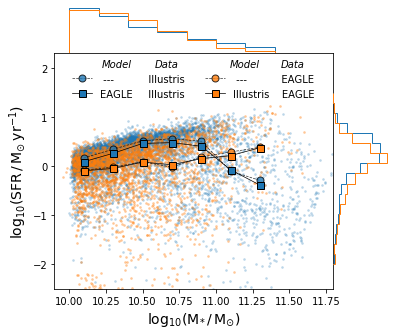

In [19]:
mstarbinLimits = np.linspace(10, 11.4, 8)
mstarbins = np.linspace(10.1, 11.3, 7)
sfr_bins = np.linspace(-2.0, 1.5, 18)

fig = plt.figure(figsize=(6, 5.2))

gs = gridspec.GridSpec(6, 6)
gs.update(hspace=0, wspace=0)

ax3 = plt.subplot(gs[1:6, 0:5])
ax1 = plt.subplot(gs[1:6, 5])
ax2 = plt.subplot(gs[0, 0:5])


for c,key,lab,lab2,tlab,alpha in zip(['C0','C1'],
                 ['eagle-illustris','illustris-eagle'],
                 ['EAGLE     Illustris','Illustris    EAGLE'],
                 [' ---           Illustris',' ---           EAGLE'],
                 ['illustris','eagle'],[0.2,0.3]):
    
    print(c)

    pred_mass = np.log10(np.sum(prediction[key] * binWidths\
                                             * recycling_fraction, axis=1))

    pred_sfr = prediction[key][:,0].copy()
    pred_sfr[pred_sfr < 0] = 1e-8
    pred_sfr = np.log10(pred_sfr)
    
    ax1.hist(pred_sfr, orientation='horizontal', 
         bins=sfr_bins, alpha=1.0, color=c, density=True, histtype='step')
    
    ax2.hist(pred_mass, bins=mstarbinLimits, alpha=1.0, 
             color=c, density=True, histtype='step')

    ax3.scatter(pred_mass, pred_sfr, s=3, c=c, alpha=alpha)

    medi, dummy, dummy = binned_statistic(tuple(mstar_true[tlab]), tuple(np.log10(sfr_true[tlab])), 
                                      statistic=np.median, bins=mstarbinLimits)
    
    ax3.plot(mstarbins, medi, alpha=0.8, c='black', marker='o', linestyle='dashed', 
             fillstyle='full', markerfacecolor=c, lw=.7, ms=7, label=lab2)
    
    medi, dummy, dummy = binned_statistic(tuple(pred_mass), tuple(pred_sfr), 
                                      statistic=np.median, bins=mstarbinLimits)
    
    ax3.plot(mstarbins, medi, label=lab, alpha=1.0, c='black', marker='s',
            fillstyle='full', markerfacecolor=c, lw=.7, ms=7)


    
for ax in [ax3,ax2]:
    ax.set_xlim(9.9,11.8)

for ax in [ax3,ax1]:
    ax.set_ylim(-2.5,2.3)

ax3.text(0.17, 0.94, 'Model', transform=ax3.transAxes, style='italic')
ax3.text(0.36, 0.94, 'Data', transform=ax3.transAxes, style='italic')

ax3.text(0.63, 0.94, 'Model', transform=ax3.transAxes, style='italic')
ax3.text(0.81, 0.94, 'Data', transform=ax3.transAxes, style='italic')

ax3.legend(loc=(0.05, 0.79), frameon=False, ncol=2)

ax3.set_xlabel('$\mathrm{log_{10}(M_{*} \,/\, M_{\odot})}$', size=14)
ax3.set_ylabel('$\mathrm{log_{10}(SFR \,/\, M_{\odot} \, yr^{-1})}$', size=14)

ax1.axis('off')
ax2.axis('off')

# fig.savefig('plots/intersim_sfs_dust.png', dpi=250, bbox_inches='tight')

## Median SFH

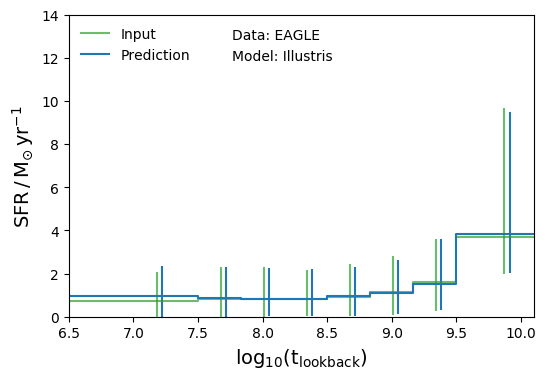

In [21]:
fig, ax = plt.subplots(1,1,dpi=100)

## Input
perc = np.percentile(predictors['eagle'], [16,50,84], axis=0)
ax.errorbar(np.log10(binLimits[:-1]*1e9 + binWidths/2)-.02, perc[1], 
             yerr=[perc[1]-perc[0], perc[2]-perc[1]], fmt='none', color='C2', alpha=0.7)

perc = np.hstack([perc, np.array([perc[:,-1]]).T])
ax.step(np.log10(binLimits*1e9), perc[1], label='Input', where='post',color='C2', alpha=0.7)

## Prediction
perc = np.percentile(prediction['illustris-eagle'], [16,50,84], axis=0)
eb = ax.errorbar(np.log10(binLimits[:-1]*1e9 + binWidths/2)+.02, perc[1], 
      yerr=[perc[1]-perc[0], perc[2]-perc[1]], fmt='none', color='C0')

perc = np.hstack([perc, np.array([perc[:,-1]]).T])
ax.step(np.log10(binLimits * 1e9), perc[1], label='Prediction', 
         where='post', color='C0')#, alpha=0.7, linestyle='dotted')


ax.set_xlabel('$\mathrm{log_{10}(t_{lookback})}$', size=14)
ax.set_ylabel('$\mathrm{SFR} \,/ \,\mathrm{M_{\odot} \, yr^{-1}}$', size=14)

ax.text(0.35, 0.92, 'Data: EAGLE', transform=ax.transAxes)
ax.text(0.35, 0.85, 'Model: Illustris', transform=ax.transAxes)

ax.set_xlim(6.5,10.1)
ax.set_ylim(0,14)

ax.legend(loc=2, frameon=False)

# fig.savefig('plots/ensemble_average_illustris-eagle.png', dpi=200, bbox_inches='tight')

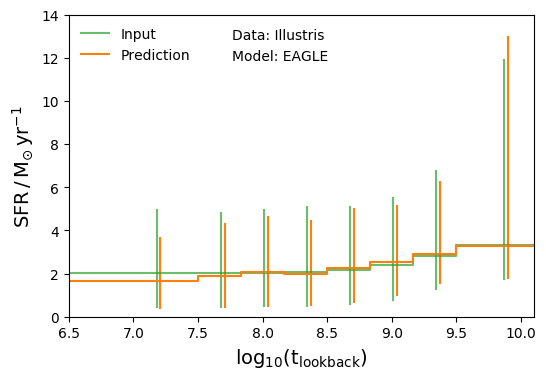

In [23]:
fig, ax = plt.subplots(1,1, dpi=100)

## Input
perc = np.percentile(predictors['illustris'], [16,50,84], axis=0)
ax.errorbar(np.log10(binLimits[:-1]*1e9 + binWidths/2)-.02, perc[1], 
             yerr=[perc[1]-perc[0], perc[2]-perc[1]], fmt='none', color='C2', alpha=0.7)

perc = np.hstack([perc, np.array([perc[:,-1]]).T])
ax.step(np.log10(binLimits * 1e9), perc[1], label='Input', where='post',color='C2', alpha=0.7)


## Prediction
perc = np.percentile(prediction['eagle-illustris'], [16,50,84], axis=0)
eb = ax.errorbar(np.log10(binLimits[:-1]*1e9 + binWidths/2)+.01, perc[1], 
      yerr=[perc[1]-perc[0], perc[2]-perc[1]], fmt='none', color='C1')

perc = np.hstack([perc, np.array([perc[:,-1]]).T])
ax.step(np.log10(binLimits * 1e9), perc[1], label='Prediction', 
         where='post', color='C1')

ax.set_xlabel('$\mathrm{log_{10}(t_{lookback})}$', size=14)
ax.set_ylabel('$\mathrm{SFR} \,/ \,\mathrm{M_{\odot} \, yr^{-1}}$', size=14)


ax.text(0.35, 0.92, 'Data: Illustris', transform=ax.transAxes)
ax.text(0.35, 0.85, 'Model: EAGLE', transform=ax.transAxes)

ax.set_xlim(6.5,10.1)
ax.set_ylim(0,14)

ax.legend(loc=2, frameon=False)

# fig.savefig('plots/ensemble_average_eagle-illustris.png', dpi=200, bbox_inches='tight')